# Halma and Reinforcement Learning

In [1]:
import numpy as np
from random import randint, random, choice
import matplotlib.pyplot as plt
from math import sqrt, log
import copy
%matplotlib inline

### Board Class for keeping track of our states and evaluating actions

In [52]:
class Board(object):
    def __init__(self, num_players, rewards):
        self.n_players = num_players
        self.rewards = rewards
        
        # we used a 4 by 4 for testing purposes, we didn't bother making it extend to larger graphs because of time constraints
        self.grid = [[0 for i in range(4)] for j in range(4)]
        
        # start with player 1 - this is our agent
        self.cur_turn = 1
        
        # for calculating distances
        self.baseCamps = {2: [0, 0], 1: [3, 3]}
        
        # keep track of where we've gone in a turn so we don't jump back and forth
        self.this_turn_visited = []
        
        self.moves = {1: 0, 2: 0}
        self.last_moved = [None, None]
        self.starting_positions = {}
        self.prevInPlace = 0
        
        # where our pieces start out
        if self.n_players == 2: 
            self.starting_positions[1] = [[0, 0], [0, 1], [1, 0]] 
            self.starting_positions[2] = [[3, 3], [2, 3], [3, 2]] 
        
    def printBoard(self):
        for r in self.grid:
            print(r)
            
    def reset(self):
        self.grid = [[0 for i in range(4)] for j in range(4)]
        if self.n_players == 2: 
            for player, lst in self.starting_positions.items():
                 for x, y in lst:
                        self.grid[x][y] = player
    
    def checkWin(self, player):
        if self.n_players == 2:
            win_positions = self.starting_positions[self.n_players - player + 1]            
            for x, y in win_positions:
                if self.grid[x][y] != player:
                    return False
            return True
                        
    def inBounds(self, i, j):
        if i < 0 or j < 0 or j > 3 or i > 3:
            return False
        return True
    
    def checkDist(self, x, y, other = None):
        if not other:
            other = self.baseCamps[3-self.cur_turn]

        baseX, baseY = other
        return ((baseY - y)**2 + (baseX-x)**2)
    
    # get the positions of all possible ending positions, including multiple jumps
    def getLegalComplete(self, i, j, positive = None):
        # BFS from i, j
        legal = {"moves": [], "jumps": []}
        if self.grid[i][j] == 0:
            return legal
        else:
            visited = [[False for q in range(4)] for z in range(4)]
            queue = [[i, j]]
            while queue:
                x, y = queue.pop(0)
                if not visited[x][y]:
                    if [x, y] != [i, j]:
                        legal["jumps"].append([x, y])
                    for k in range(-1, 2):
                        for l in range(-1, 2):
                            if self.inBounds(x + 2*k, y + 2*l) and self.grid[x + 2*k][y + 2*l] == 0 and self.grid[x + k][y + l] != 0:        
                                    if not visited[x + 2*k][y + 2*l]: 
                                        queue.append([x + 2*k, y + 2*l])
                    visited[x][y] = True        

            for k in range(-1, 2):
                    for l in range(-1, 2):                    
                        if self.inBounds(i + k, j + l) and self.grid[i + k][j + l] == 0:
                            legal["moves"].append([i + k, j + l])
            return legal
    
    # same as above, except also get their distances
    def getLegalCompleteDist(self, i, j, positive = None, dist = True):
        # BFS from i, j
        legal = {"moves": [], "jumps": []}
        if self.grid[i][j] == 0:
#             print(i, j, self.grid[i])
#             print("Why are you trying to move a blank space?")
            return legal
        else:
            visited = [[False for q in range(4)] for z in range(4)]
            queue = [[i, j, self.checkDist(i, j, other = positive)]]
            while queue:
                x, y, d = queue.pop(0)
                if not visited[x][y]:
                    if [x, y] != [i, j]:
                        legal["jumps"].append([x, y, d])
                    for k in range(-1, 2):
                        for l in range(-1, 2):
                            myDist = self.checkDist(x, y, other = positive)
                            if self.inBounds(x + 2*k, y + 2*l) and self.grid[x + 2*k][y + 2*l] == 0 and self.grid[x + k][y + l] != 0:        
                                    if not visited[x + 2*k][y + 2*l]: 
                                        newDist = self.checkDist(x + 2*k, y + 2*l, other = positive)
                                        if ((not dist) or myDist > newDist):
                                            queue.append([x + 2*k, y + 2*l, newDist])
                    visited[x][y] = True        

            for k in range(-1, 2):
                    for l in range(-1, 2):  
                        myDist = self.checkDist(i, j, other = positive)
                        if self.inBounds(i + k, j + l) and self.grid[i + k][j + l] == 0:
                            newDist = self.checkDist(i + k, j + l, other = positive)
                            if ((not dist) or myDist > newDist):
                                legal["moves"].append([i + k, j + l, newDist])
            return legal
            
    def checkLegal(self, player, i, j, k, l):
        if self.grid[k][l] != 0 or self.grid[i][j] != player:
            return False
        else:
            return True
            
    def move(self, player, i, j, k, l, pBoard = False):
        if self.checkLegal(player, i, j, k, l) == True and self.cur_turn == player:
            self.grid[i][j] = 0
            self.grid[k][l] = player
            
            # change the turns, increment how much a player has moved
            self.cur_turn = 3 - self.cur_turn
            self.moves[player] += 1
            if pBoard:
                self.printBoard()
        else:
            # the move wasn't legal, yell at the person
            print("WE FAILED TO MAKE A MOVE with player", player, self.checkLegal(player, i, j, k, l), self.cur_turn == player, i, j, k, l)
            self.cur_turn = 3 - self.cur_turn
        

### Agent Class for interacting with the board - this is our Naive Agent

In [4]:
class Agent(object):
    def __init__(self, board, ID, baseOrigin):
        self.ID = ID
        self.baseOrigin = baseOrigin
        self.board = board
        self.pieces = self.board.starting_positions[self.ID]
        self.overrideDist = False
    
    def updateBoard(self, board):
        self.board = board
    
    def findPieces(self, board):
        pieces = []
        for i in range(len(board.grid)):
            for j in range(len(board.grid[i])):
                if board.grid[i][j] == self.ID:
                    pieces.append([i, j])
        return pieces
    
    def distToOther(self, piece, other = None):
        if not other:
            other = self.baseOrigin
        baseX, baseY = other
        pieceX, pieceY = piece
        return ((baseY - pieceY)**2 + (baseX-pieceX)**2)**.5
    
    def bestPiece(self, distPieces = None, mp = None, dist = True): 
        if not distPieces:
            distPieces = sorted([[self.distToOther(piece), piece] for piece in self.pieces])

        for piece in distPieces:
            i, j = piece[1]
            legals = self.board.getLegalCompleteDist(i, j, positive = mp, dist = dist)
            if legals["jumps"] or legals["moves"]:
                return [(i, j), legals]
        return [False, False]
    
    def bestMove(self, eps = .2):            
        if self.overrideDist:
            # Find the pieces that are not in the right positions
            s = self.board.starting_positions[self.board.n_players-self.ID+1]
            missedPieces = [x for x in self.pieces if x not in s]
            
            # Find the first missing position
            missedPos = [x for x in s if x not in self.pieces]
            if not missedPos:
                print("Erroneous")
                return False
            mp = missedPos[0]
            
            # Calculate distances and find best move using those
            distPieces = sorted([[self.distToOther(piece, mp), piece] for piece in missedPieces], reverse=True)         
            piece, legals = self.bestPiece(distPieces = distPieces, mp = mp)
            if not piece or not legals:
                piece, legals = self.bestPiece(distPieces = distPieces, mp = mp, dist = False)            
        else:
            piece, legals = self.bestPiece()
        
        if not piece or not legals:
            return False
        
        if legals["jumps"]:
            distJumps = sorted(legals["jumps"], reverse=True, key=lambda i: i[2])
            if random() < eps:
                target = choice(distJumps)
            else:
                target = distJumps[0]
            return [piece[0], piece[1], target[0], target[1]]

        elif legals["moves"]:
            distMoves = sorted(legals["moves"], reverse=True, key=lambda i: i[2])
            if random() < eps:
                target = choice(distMoves)
            else:
                target = distMoves[0]
            return [piece[0], piece[1], target[0], target[1]]
        
        else:
            return False
    
    def move(self):
        move = self.bestMove()
        
        # If no move available, clearly we are in a deadlock
        if not move:
            self.overrideDist = True
            move = self.bestMove()
            if not move:
                return False
        
        # Make move on board and record pieces
        i, j, k, l = move
        self.board.move(self.ID, i, j, k, l)
        self.pieces = self.findPieces(self.board)
        
        return move

In [5]:
board = Board(2, 0)
board.reset()
player = Agent(board, 1, [0, 0])
opponent = Agent(board, 2, [3, 3])
runs = 0
for i in range(100):
    if board.checkWin(1) or board.checkWin(2):
        print i
        runs = i
        break
    mv = player.move()

    mv = opponent.move()

    if i > 30:
        board.printBoard()
        print "-------"

9


In [6]:
moveRew = -.1
winRew = 2
def PlayGame(nplayers = 2):
    brd = Board(nplayers, 0)
    brd.reset()
    opponent = Agent(brd, 2, [15, 15])
    player = Agent(brd, 1, [0, 0])
    players = [player, opponent]
    
# #     for i in range(250):
# #         opponent.move()
# #         player.move()

    rewards = {1: [], 2: []}
    m, m1 = 0, 0
    c = 0
    while True:
        for p in players:
            # Check if game is ended
            if brd.checkWin(p.ID or c > 20):
                rewards[p.ID].append(winRew)
                return p, rewards
            p.move()
            rewards[p.ID].append(moveRew)
            brd = p.board
        c+=1

In [7]:
lol = PlayGame()

In [8]:
plays = 200

In [12]:
wins = {1: 0, 2: 0}
rews = {1: [], 2: []}
for i in range(plays):
    p, r = PlayGame()
    wins[p.ID] += 1
    rews[1].append(np.sum(r[1]))
    rews[2].append(np.sum(r[2]))
cumrews = {1: np.cumsum(rews[1]), 2: np.cumsum(rews[2])}

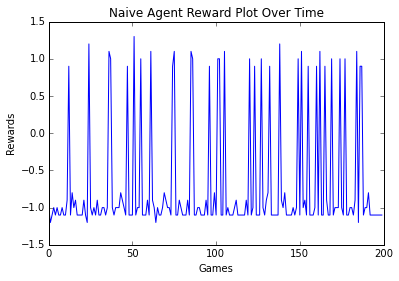

In [13]:
x = np.arange(0, plays, 1)
y = map(lambda x: rews[1][x], x)

plt.xlabel("Games")
plt.ylabel("Rewards")
plt.title("Naive Agent Reward Plot Over Time")
plt.plot(x, y)

### State Class for managing the Board in MCTS

In [252]:
class HalmaState:
    def __init__(self, players = 2, rewards = 0, opp = None, iters = 500):
        self.nplayers = 2
        self.rewards = 0
        self.board = Board(players, rewards)
        self.board.reset()
        self.opp = Agent(self.board, 2, [3, 3])
        self.size = len(self.board.grid)
        self.iters = iters

    # create a copy of our state
    def Clone(self):
        st = HalmaState()
        
        # copy the grid
        st.board.grid = [row[:] for row in self.board.grid]
        
        # copy the agent
        st.opp =  Agent(st.board, 2, [3, 3])

        return st

    # perform a move, and then immediately execute the opponent's move before giving control back 
    def DoMove(self, move):
        
        self.board.grid = [row[:] for row in self.opp.board.grid]
        i, j, k, l = move
        
        if self.board.cur_turn != 1:
            print("something's wrong with cur_turn (should be 1)")
            
        self.board.move(1, i, j, k, l)
        
        if self.board.cur_turn != 2:
            print("something's wrong with cur_turn (should be 2)")
            
        self.opp.board.grid = [row[:] for row in self.board.grid]
        
        self.opp.pieces = self.opp.findPieces(self.opp.board)
        self.opp.move()
        
        self.board.grid = [row[:] for row in self.opp.board.grid]

        if self.board.cur_turn != 1:
            print("something's wrong with cur_turn (should be 1) - step 2")
        
        if self.board.checkWin(1):
            return 1
        elif self.board.checkWin(2):
            return 2
        else:
            return None        
    
    # get all the available moves from this current state for player 1
    def GetMoves(self):
        
        moves = {"moves": [], "jumps": []}
        self.board.grid = [row[:] for row in self.opp.board.grid]
        
        if self.board.checkWin(1) or self.board.checkWin(2):
            return moves
        
        for i in range(len(self.board.grid)):
            for j in range(len(self.board.grid)):
                if self.board.grid[i][j] == 1:
                    legals = self.board.getLegalComplete(i, j)
                    if legals["moves"]:
                        moves["moves"] += ([[i, j, k, l] for k, l in legals["moves"] if [i, j, k, l] not in moves["moves"]])
                    if legals["jumps"]:
                        moves["jumps"] += ([[i, j, k, l] for k, l in legals["jumps"] if [i, j, k, l] not in moves["jumps"]])
        
        if (moves["moves"] == [] and moves["jumps"] == []):
            print("something went wrong")
        return moves
    
    # check if one of the players has one and reward accordingly
    def GetResult(self, player):

        if self.board.checkWin(1):
            rew = self.iters * 100
        elif self.board.checkWin(2):
            rew = -100

        return rew

    def __repr__(self):
        s= ""
        for x in range(len(self.board.grid)):
            for y in range(len(self.board.grid[x])):
                s += ["[_]","[X]","[O]"][self.board.grid[x][y]]
            s += "\n"
        return s

### Node Class for MCTS Tree Creation

In [253]:
class Node:
    def __init__(self, move = None, moveType = None, parent = None, state = None):
        # the move that got us to this node - "None" for the root node
        self.move = move 
        
        # "None" for the root node
        self.parentNode = parent 
        
        self.moveType = moveType
        self.childNodes = []
        self.wins = 0
        self.visits = 0
        self.state = state
        
        # future child nodes
        self.untriedMoves = state.GetMoves() 
        self.playerJustMoved = state.board.cur_turn 
    
    # this is the way UCT selects child nodes
    def UCTSelectChild(self):
        s = sorted(self.childNodes, key = lambda c: c.wins/c.visits + sqrt(2*log(self.visits)/c.visits))[-1]
        return s
    
    # create a new node, and make sure we tell our current state that we've now tried this move 
    def AddChild(self, m, s, moveType = "moves"):
        n = Node(move = m, moveType = moveType, parent = self, state = s)
        self.untriedMoves[moveType].remove(m)
        self.childNodes.append(n)
        return n
    
    # for backpropagation
    def Update(self, result):
        self.visits += 1
        self.wins += result

    def __repr__(self):
        return "[M:" + str(self.move) + " MT:" + str(self.moveType) + " W/V:" + str(self.wins) + "/" + str(self.visits) + " U:" + str(self.untriedMoves) + "]"

### UCT Class, for one move in the MCTS algorithm 

In [254]:
def UCT(rootstate, itermax, verbose = False):

    # start at the root
    rootnode = Node(state = rootstate)
    rewardz = []
    
    # let's learn!
    for iters in range(itermax):
        node = rootnode
        state = rootstate.Clone()
        winner = None
        
        # select a child node
        while not node.untriedMoves["moves"] and not node.untriedMoves["jumps"] and node.childNodes != []: # node is fully expanded and non-terminal
            node = node.UCTSelectChild()
            winner = state.DoMove(node.move)
            node.untriedMoves
            if winner:
                break
        
        # perform expansion 
        if node.untriedMoves["moves"] or node.untriedMoves["jumps"] and not winner: 
            m = choice(node.untriedMoves["moves"] + node.untriedMoves["jumps"])
            i, j, k, l = m
            testing = 0
            while not state.board.checkLegal(1, i, j, k, l):
                
                m = choice(node.untriedMoves["moves"] + node.untriedMoves["jumps"])
                i, j, k, l = m
                testing = testing + 1
                if testing == 500:
                    print(node.untriedMoves["moves"] + node.untriedMoves["jumps"])
                    node.state.board.printBoard()
                    print(node.state.board.cur_turn)

            winner = state.DoMove(m)
            if winner:
                break

            mt = "moves"
            if m in node.untriedMoves["jumps"]:
                mt = "jumps"
            node = node.AddChild(m, state, mt) 
        
        mvs = state.GetMoves()
        
        # perform the rollout phase, simulate the rest of the game 
        while mvs["moves"] or mvs["jumps"] and not winner: 
            mv = choice(mvs["moves"] + mvs["jumps"])
            i, j, k, l = mv

            while not state.board.checkLegal(1, i, j, k, l):
                mv = choice(mvs["moves"] + mvs["jumps"])
                i, j, k, l = mv

            if mv in mvs["moves"]:
                mvs["moves"].remove(mv)
            elif mv in mvs["jumps"]:
                mvs["jumps"].remove(mv)
            
            winner = state.DoMove(mv)
            if winner:
                break
            mvs = state.GetMoves()
        
        if winner:
            node.childNodes = []
            node.untriedMoves = {"moves": [], "jumps": []}
        
        # Backpropagate
        base = True
        backprops = 0
        while node != None: 
            # backpropagate from the expanded node and work back to the root node
            test = state.GetResult(node.playerJustMoved)
            node.Update(test) 
            if base:
                rewardz.append(node.wins)
                base = False
            node = node.parentNode
            backprops += 1
        if backprops > 3:
            print backprops
     
    if not rootnode.childNodes:
        return rootnode.move
    byVisits = sorted(rootnode.childNodes, key = lambda c: c.visits)[-1]
    byWins = sorted(rootnode.childNodes, key = lambda c: c.wins)[-1]

    return byVisits.move, rewardz

moveRew = -1
winRew = 100


### MCTS Class, plays the game 

In [ ]:
def UCTPlayGame(iters = 500):
    rewards = {1: [], 2: []}
    state = HalmaState(iters = iters)
    c = 0
    while (state.GetMoves()["jumps"] != [] or state.GetMoves()["moves"] != []):
        if state.board.cur_turn == 1:
            m, rewardz = UCT(rootstate = state, itermax = iters, verbose = False) # play with values for itermax and verbose = True
        else:
            print("WE SHOULDNT SEE THIS EVER")
        if m:
            state.DoMove(m)
            rewards[1].append(rewardz)
        else:
            print("premature break")
            break

    if state.board.checkWin(1):
        rewards[1].append(winRew)
        return 1, rewards
    elif state.board.checkWin(2):
        rewards[2].append(winRew)
        return 2, rewards
    else:
        return 3-state.board.cur_turn, rewards

In [262]:
bigDepth = UCTPlayGame(iters = 30000)

In [263]:
print(len(bigDepth[1][1]), bigDepth[0])

(15, 2)


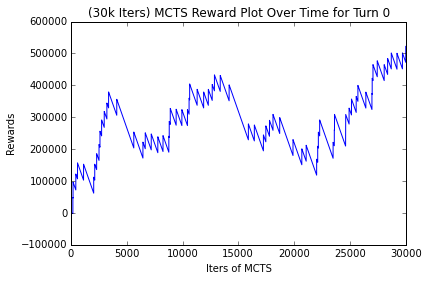

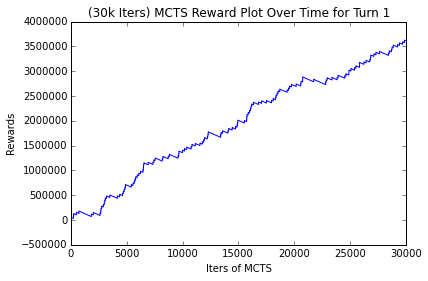

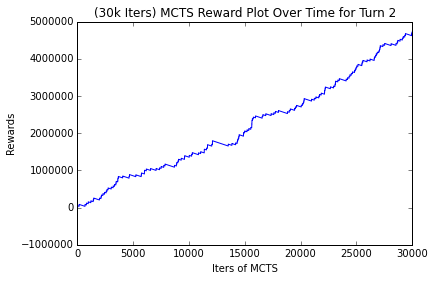

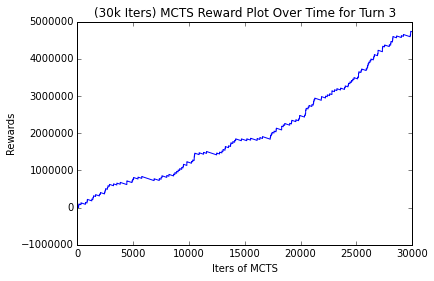

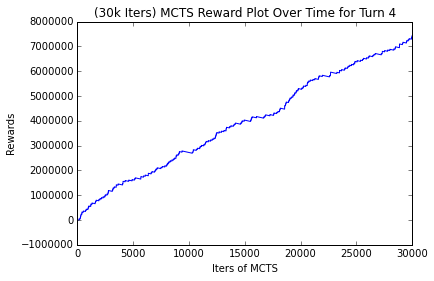

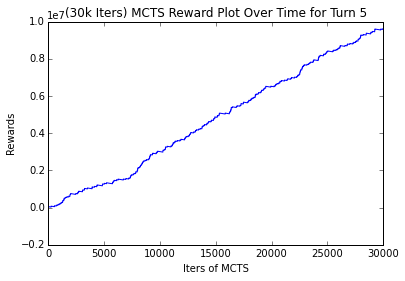

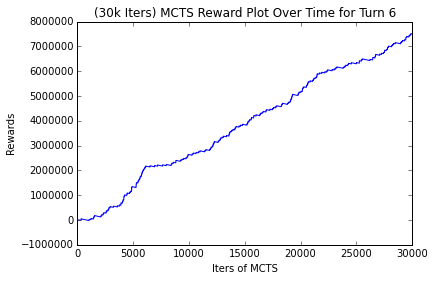

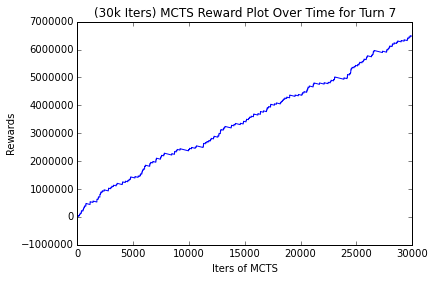

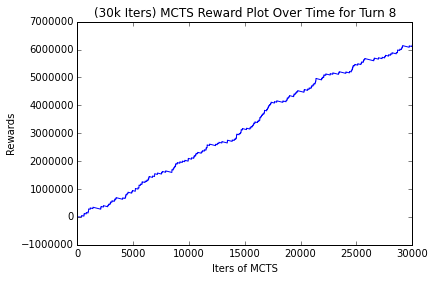

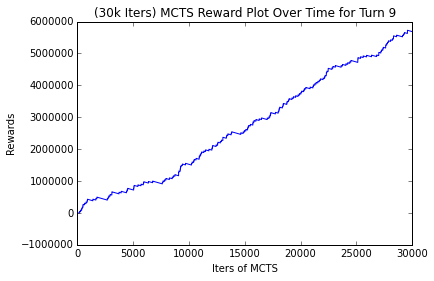

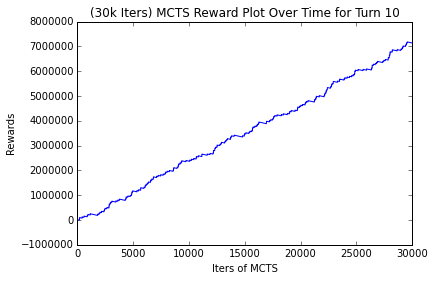

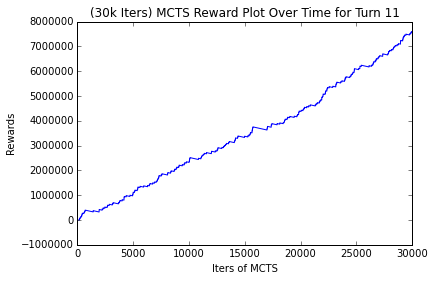

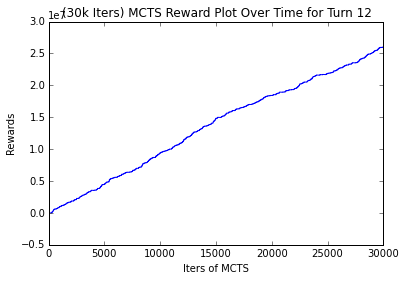

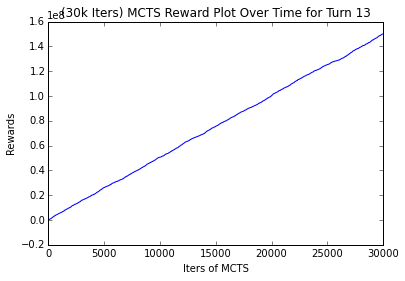

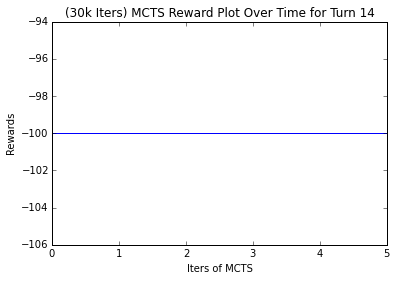

In [264]:
for mv in range(len(bigDepth[1][1])):
    iters = len(bigDepth[1][1][mv])
    x = np.arange(0, iters, 1)
    y = map(lambda x: bigDepth[1][1][mv][x], x)
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    
    ax1.set_xlabel("Iters of MCTS")
    ax1.set_ylabel("Rewards")
    ax1.set_title("(30k Iters) MCTS Reward Plot Over Time for Turn " + str(mv))
    
    ax1.plot(x, y)

In [259]:
medDepth = UCTPlayGame(iters = 10000)

In [260]:
print(len(medDepth[1][1]), medDepth[0])

(16, 2)


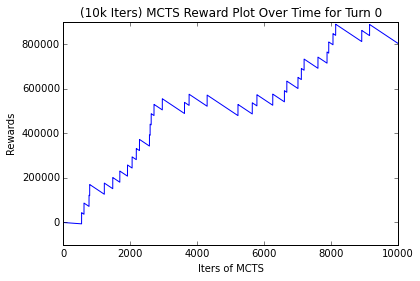

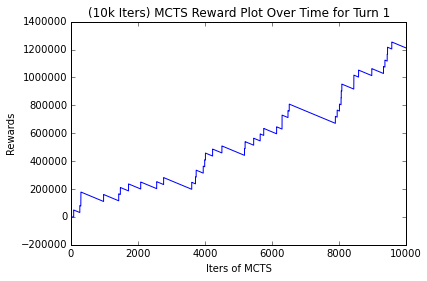

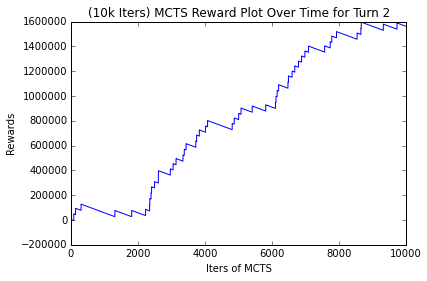

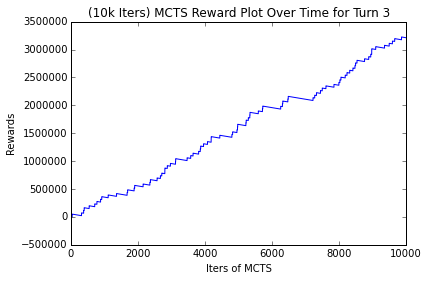

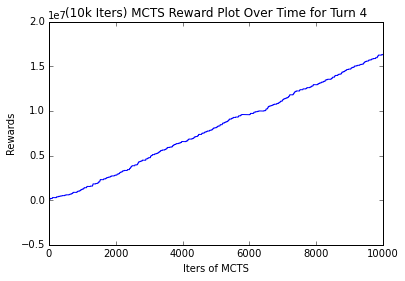

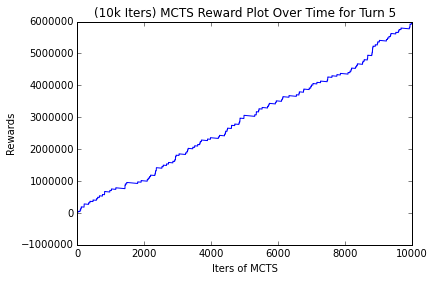

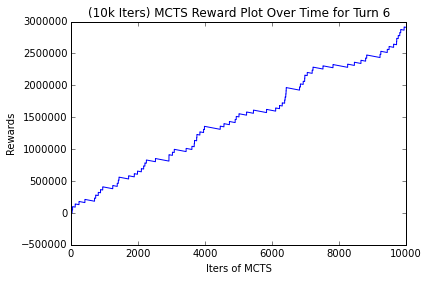

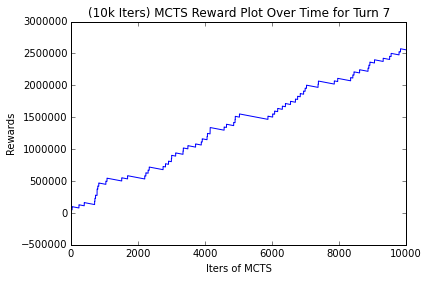

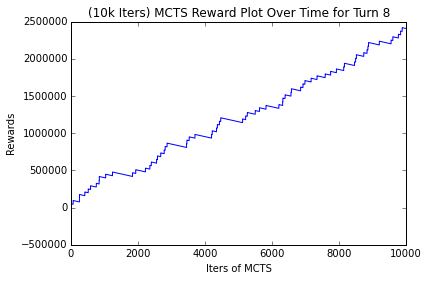

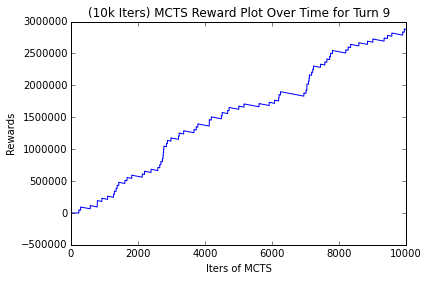

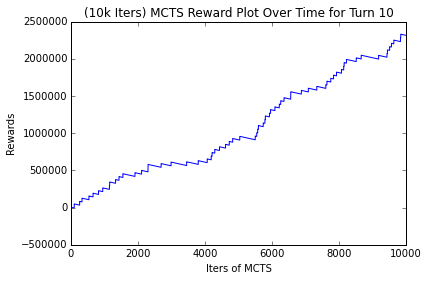

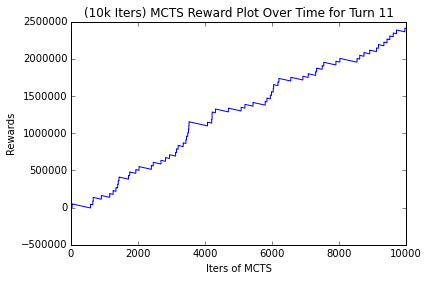

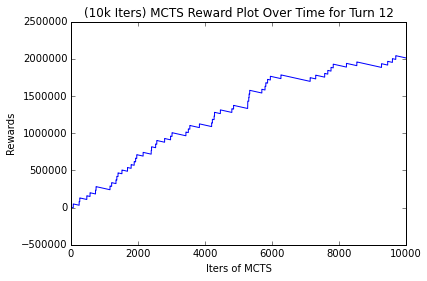

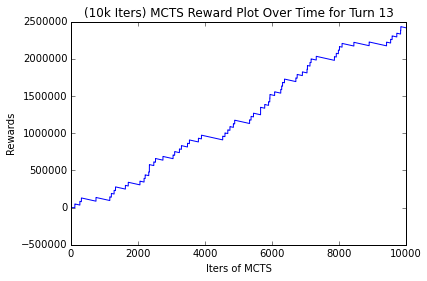

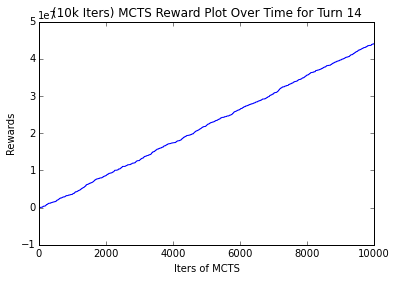

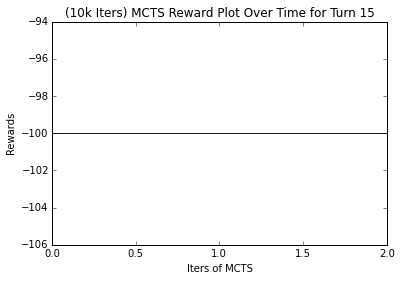

In [261]:
for mv in range(len(medDepth[1][1])):
    iters = len(medDepth[1][1][mv])
    x = np.arange(0, iters, 1)
    y = map(lambda x: medDepth[1][1][mv][x], x)
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    
    ax1.set_xlabel("Iters of MCTS")
    ax1.set_ylabel("Rewards")
    ax1.set_title("(10k Iters) MCTS Reward Plot Over Time for Turn " + str(mv))
    
    ax1.plot(x, y)

In [255]:
medLowDepth = UCTPlayGame(iters = 2000)

In [256]:
print(len(medLowDepth[1][1]), medLowDepth[0])

(15, 2)


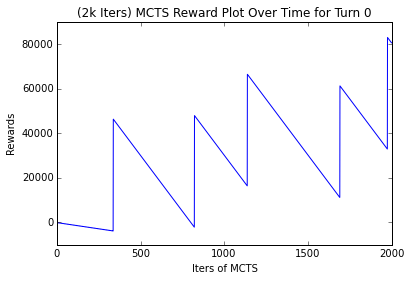

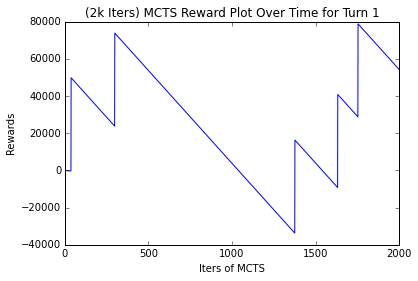

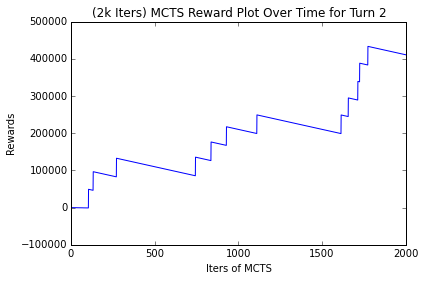

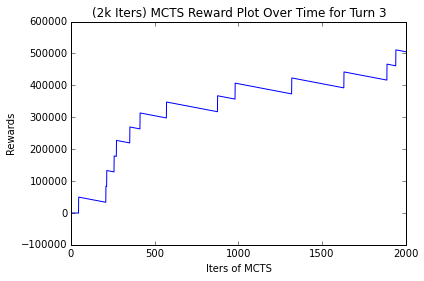

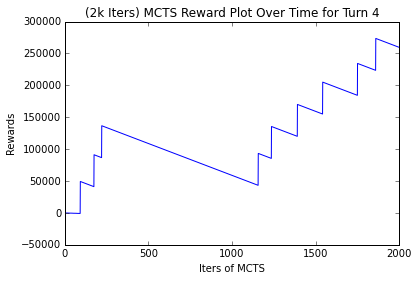

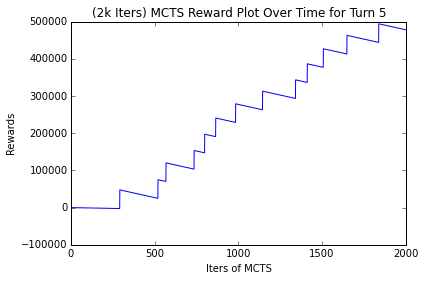

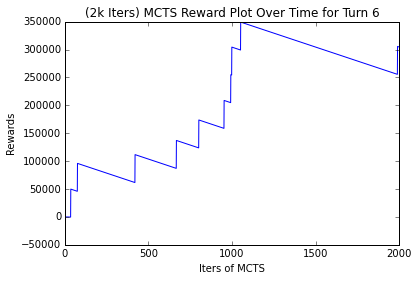

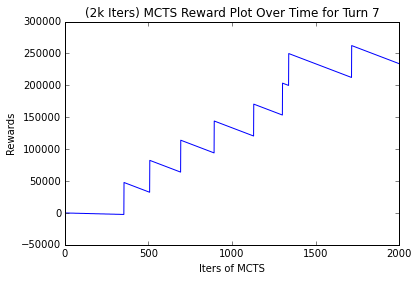

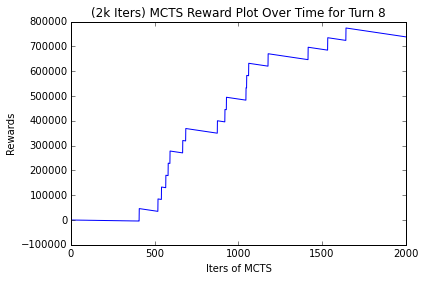

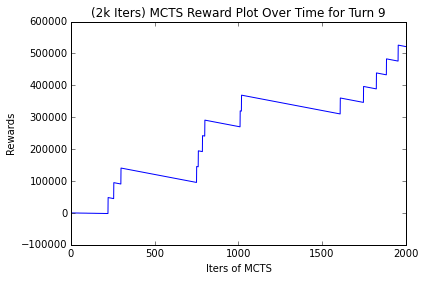

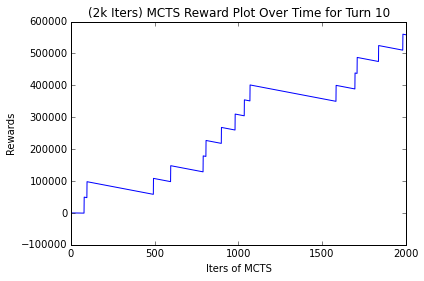

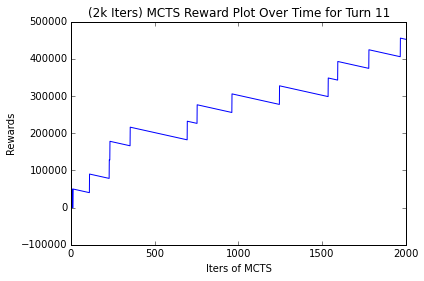

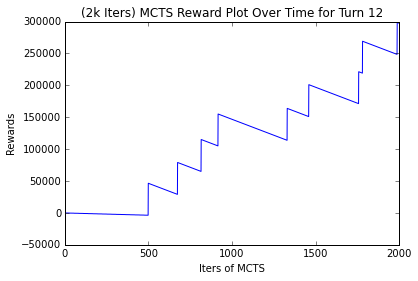

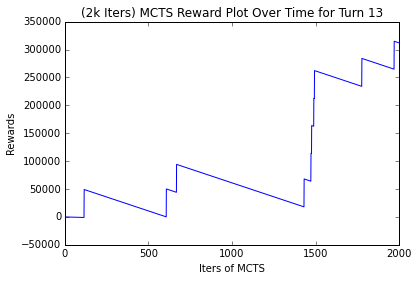

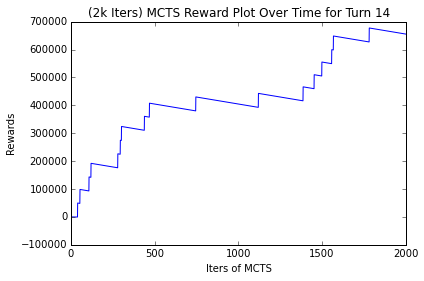

In [258]:
for mv in range(len(medLowDepth[1][1])):
    iters = len(medLowDepth[1][1][mv])
    x = np.arange(0, iters, 1)
    y = map(lambda x: medLowDepth[1][1][mv][x], x)
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    
    ax1.set_xlabel("Iters of MCTS")
    ax1.set_ylabel("Rewards")
    ax1.set_title("(2k Iters) MCTS Reward Plot Over Time for Turn " + str(mv))
    
    ax1.plot(x, y)

In [241]:
smallDepth = UCTPlayGame(iters = 500)

In [242]:
print(len(smallDepth[1][1]), smallDepth[0])

(14, 2)


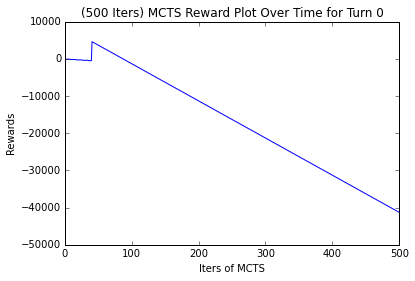

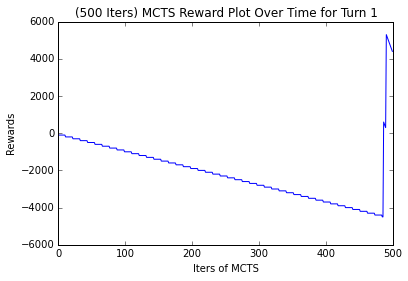

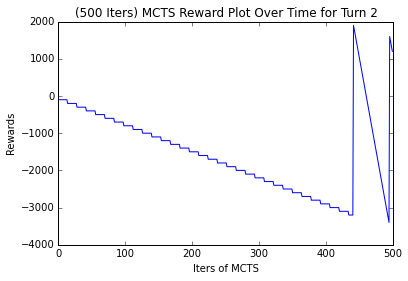

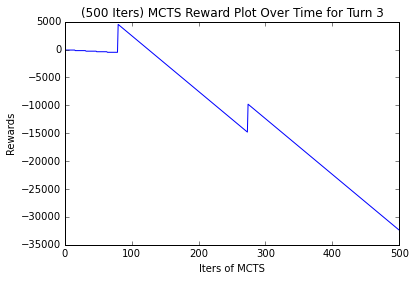

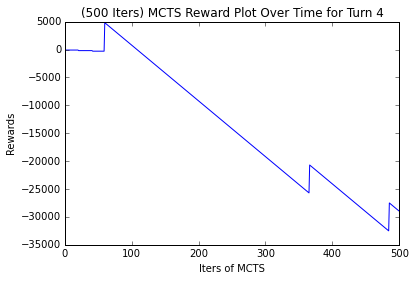

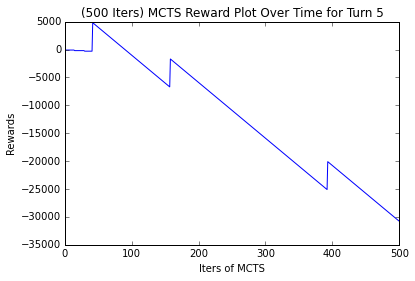

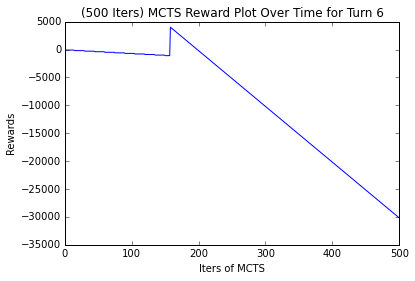

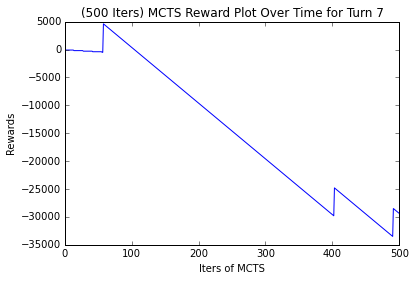

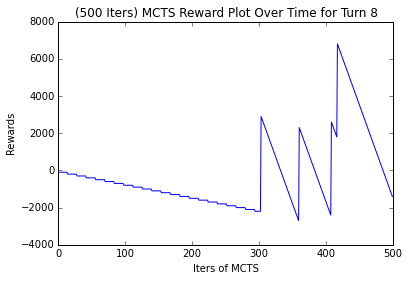

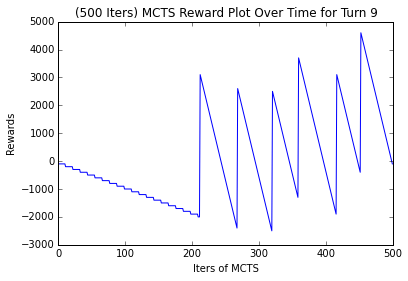

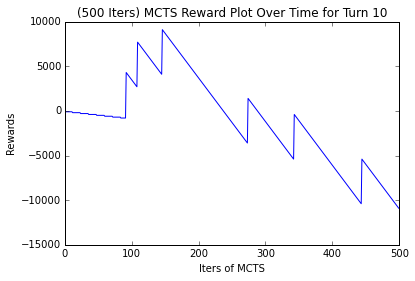

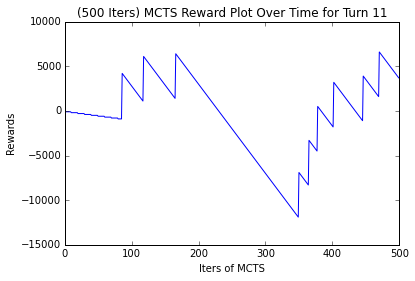

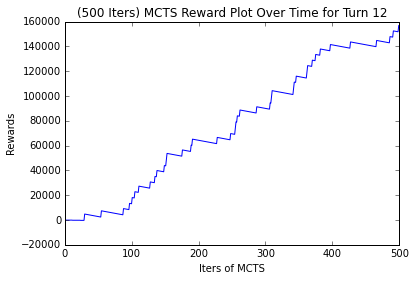

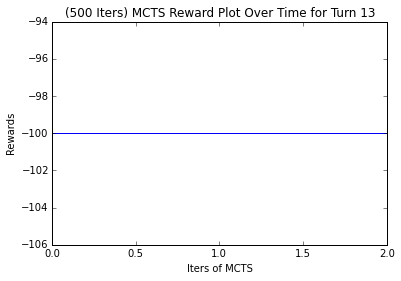

In [243]:
for mv in range(len(smallDepth[1][1])):
    iters = len(smallDepth[1][1][mv])
    x = np.arange(0, iters, 1)
    y = map(lambda x: smallDepth[1][1][mv][x], x)
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    
    ax1.set_xlabel("Iters of MCTS")
    ax1.set_ylabel("Rewards")
    ax1.set_title("(500 Iters) MCTS Reward Plot Over Time for Turn " + str(mv))
    
    ax1.plot(x, y)